In [192]:
from __future__ import print_function, division
import geopandas as gp
import pandas as pd
import pylab as pl
import os
import json
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pandas.tools.plotting import scatter_matrix
%pylab inline

PUIDATA = os.getenv("PUIDATA")

Populating the interactive namespace from numpy and matplotlib


In [193]:
#read data files
nrg = gp.GeoDataFrame.from_csv(PUIDATA + '/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv')
bsize = gp.GeoDataFrame.from_file(PUIDATA + '/Manhattan/MNMapPLUTO.shp')

In [194]:
print (nrg.columns)
print (bsize.columns)

Index([u'NYC Borough, Block, and Lot (BBL)', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Zip Code',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings'],
      dtype='object')
Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
 

In [195]:
#select the columns we need to a new dataframe
nrg1 = pd.DataFrame(nrg.loc[:,('Site EUI(kBtu/ft2)', 'NYC Borough, Block, and Lot (BBL)',  'Reported Property Floor Area (Building(s)) (ft²)')])
nrg1.head()

,Site EUI(kBtu/ft2),"NYC Borough, Block, and Lot (BBL)",Reported Property Floor Area (Building(s)) (ft²)
Record Number,,,
12086,NaN,1.000410e+09,918919
14354,NaN,4.021460e+09,NaN
12150,NaN,2.027620e+09,64200
12590,NaN,1.006700e+09,NaN
15591,NaN,2.048300e+09,50000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f73fed22450>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f73fd94c090>]], dtype=object)

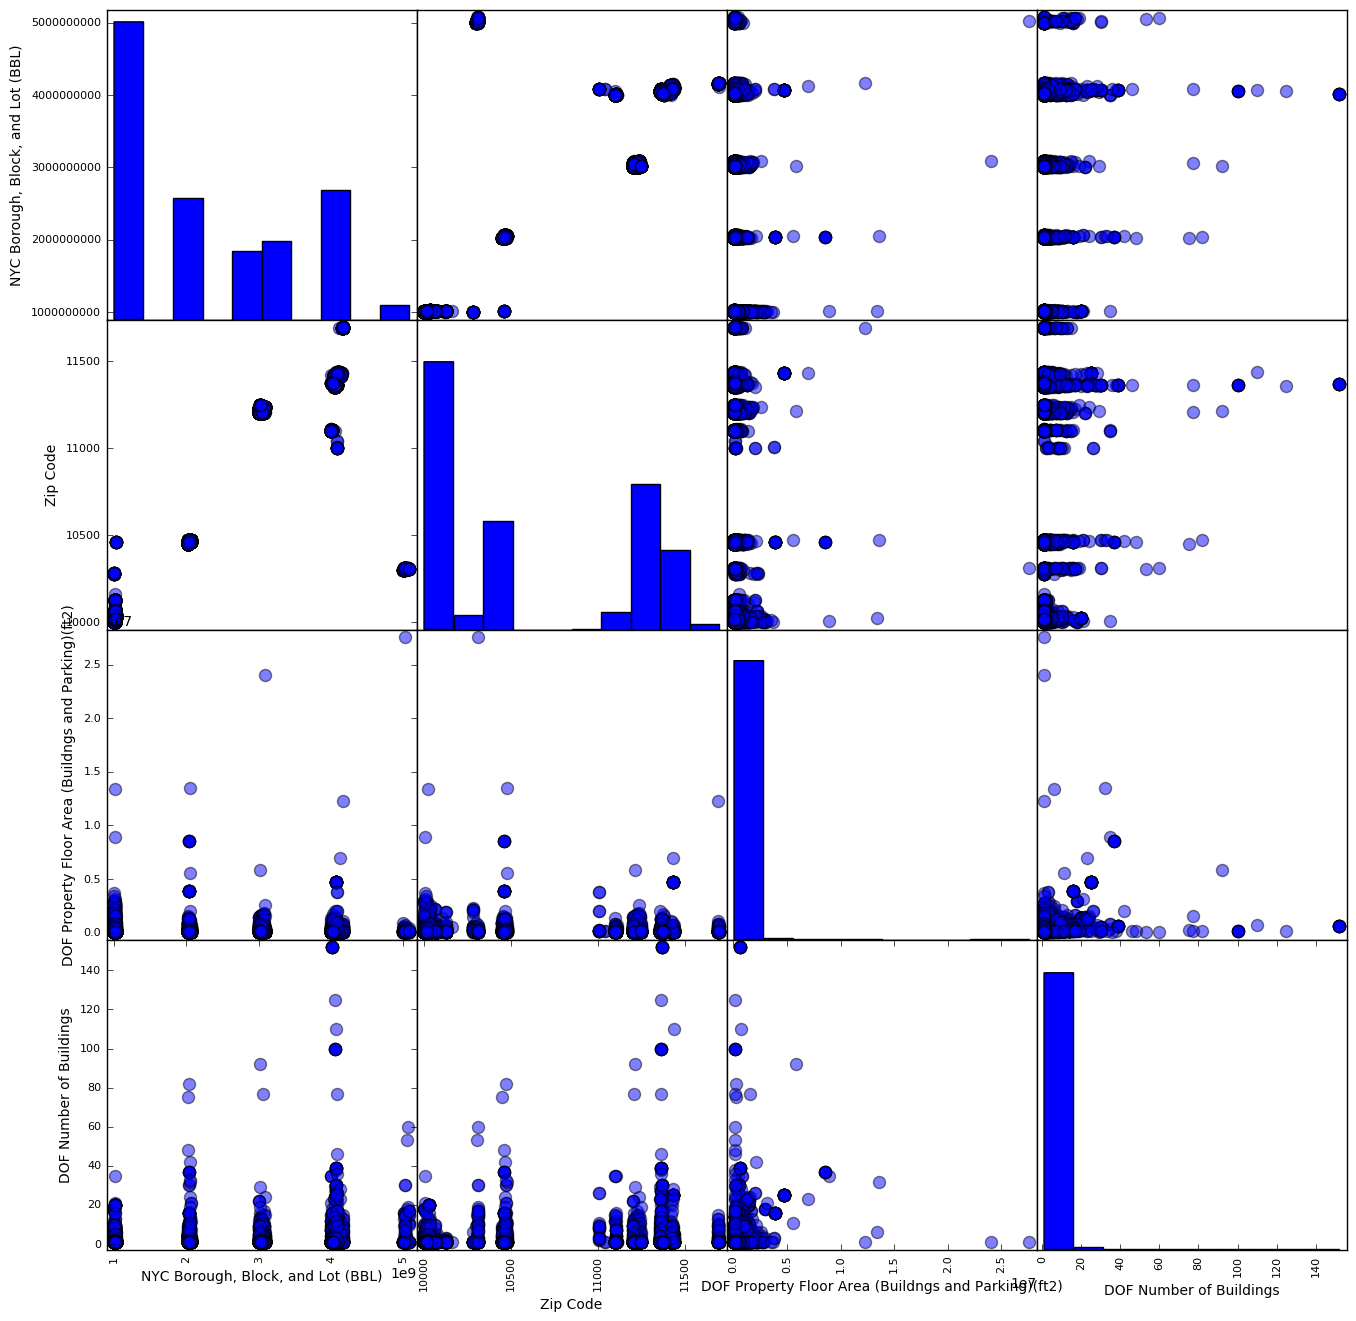

In [196]:
#make a matrix plot to get an overview of the data
scatter_matrix (nrg, s=300, figsize=(16, 16))

In [197]:
def canconvert(mydata):
    '''
    returns data with float type
    '''
    try :
        float(mydata)
        return True
    except ValueError:
        return False

In [198]:
# convert type to float. Append float NaN to cells can not be converted.
indx1 = (np.vectorize(canconvert)(nrg1['Site EUI(kBtu/ft2)']))
print ("invalid entries changed to NaN %d"%sum(indx1))
nrg1['Site EUI(kBtu/ft2)'][~indx1] = float(NaN)

indx2 = (np.vectorize(canconvert)(nrg1['Reported Property Floor Area (Building(s)) (ft²)']))
print ("invalid entries changed to NaN %d"%sum(indx2))
nrg1['Reported Property Floor Area (Building(s)) (ft²)'][~indx2] = float(NaN)

indx3 = (np.vectorize(canconvert)(nrg1['NYC Borough, Block, and Lot (BBL)']))
print ("invalid entries changed to NaN %d"%sum(indx3))
nrg1['NYC Borough, Block, and Lot (BBL)'][~indx3] = float(NaN)

invalid entries changed to NaN 15513


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


invalid entries changed to NaN 15430
invalid entries changed to NaN 16170


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [199]:
# changing column name to keep consistency
nrg1 = nrg1.rename(columns = {'NYC Borough, Block, and Lot (BBL)' : 'BBL'})
# choosing data we need from bsize data
bsize1 = pd.DataFrame(bsize.loc[:,['BBL' , 'UnitsTotal', 'YearBuilt', 'UnitsRes']])
# adding a new column suggesting energy consumption
nrg1['energy_consum'] = nrg1['Site EUI(kBtu/ft2)'].astype(float) * nrg1['Reported Property Floor Area (Building(s)) (ft²)'].astype(float)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f73fdb0a8d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f74036aa5d0>]], dtype=object)

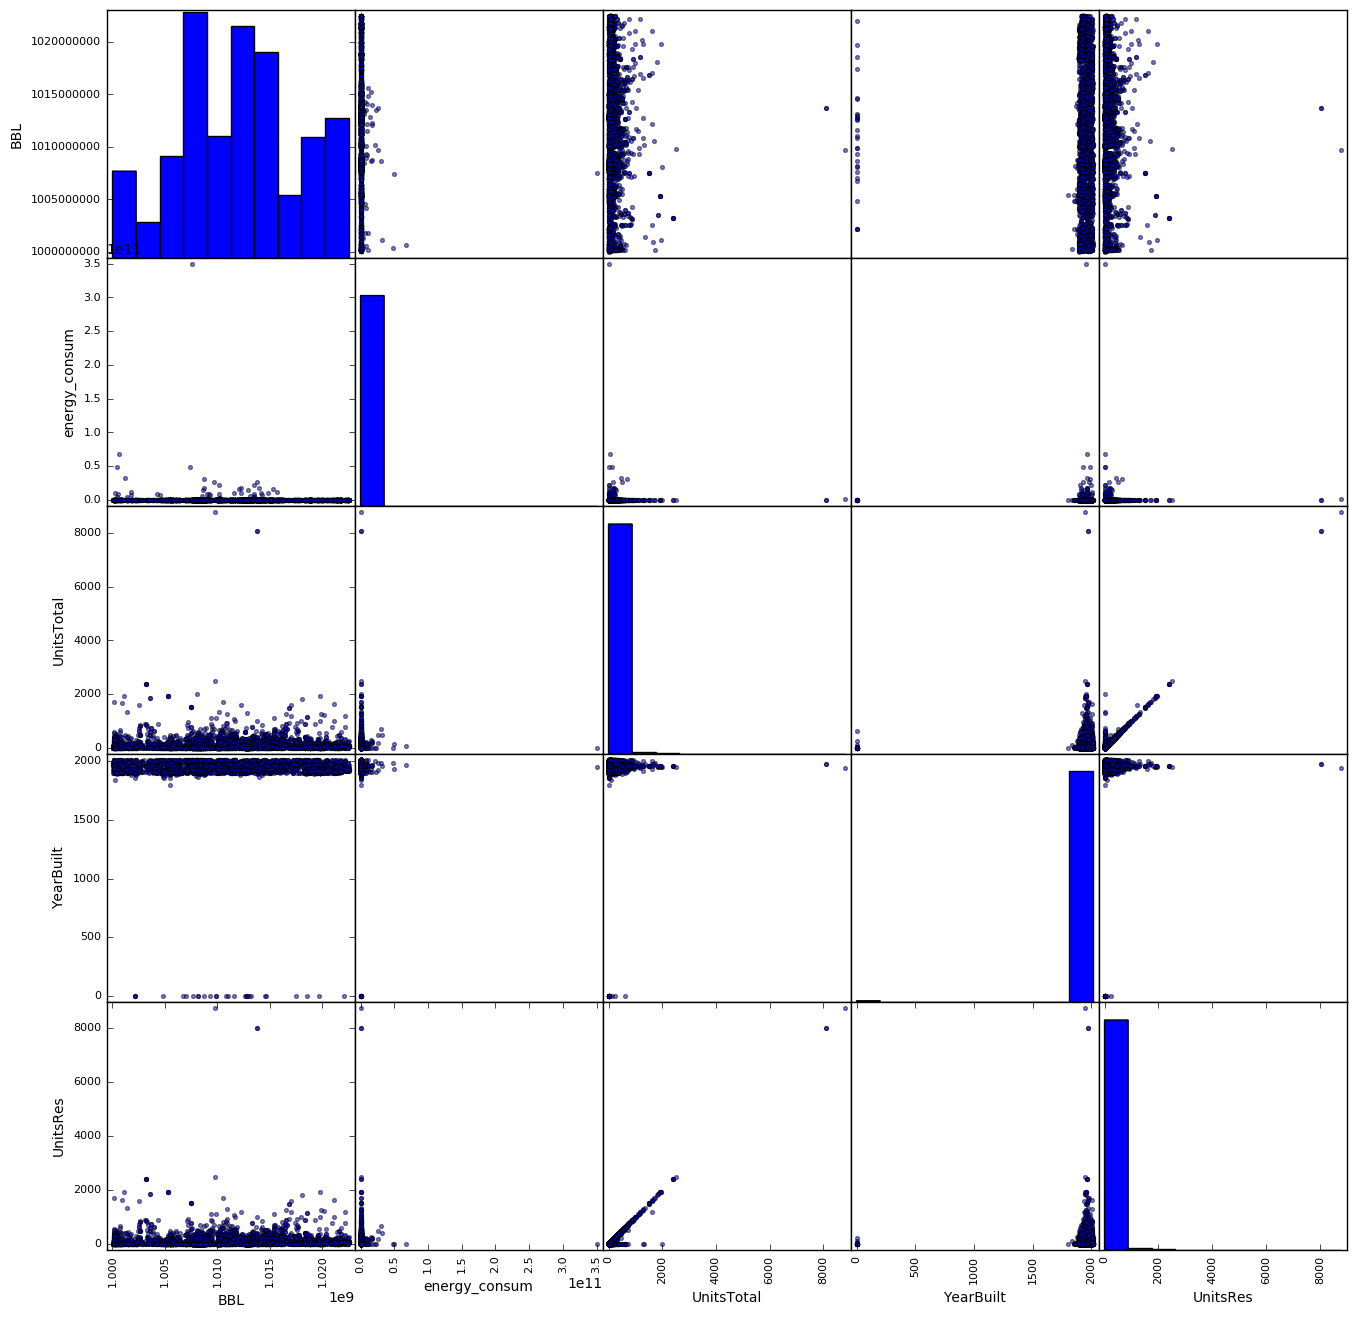

In [200]:
# merge the two dataframes according to BBL
BBLnrgdata = pd.merge(nrg1, bsize1, on = 'BBL')
scatter_matrix (BBLnrgdata, s=30, figsize=(16, 16))

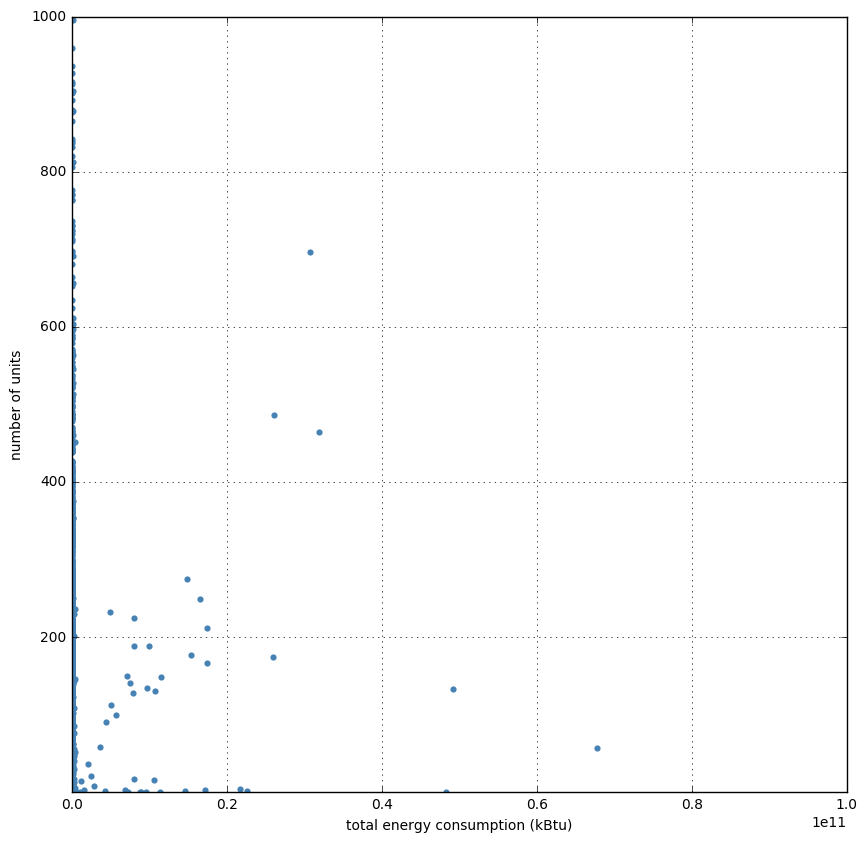

In [201]:
# make the plot

figure = plt.figure(figsize=[10,10])
plt.scatter(BBLnrgdata['energy_consum'] ,BBLnrgdata['UnitsTotal'], lw=0, color='SteelBlue')
plt.xlim([0,1e11])
plt.ylim([1, 1000])
plt.xlabel('total energy consumption (kBtu)')
plt.ylabel('number of units')
plt.grid()

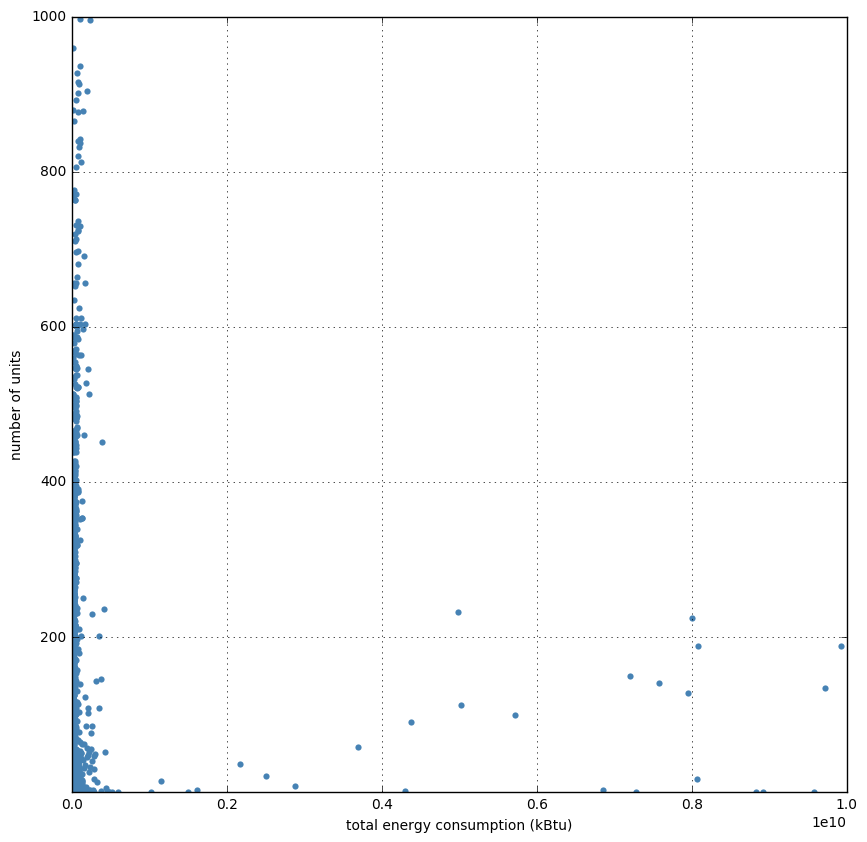

In [202]:
#now we zoom in
figure = plt.figure(figsize=[10,10])
plt.scatter(BBLnrgdata['energy_consum'] ,BBLnrgdata['UnitsTotal'], lw=0, color='SteelBlue')
plt.xlim([0,1e10])
plt.ylim([1, 1000])
plt.xlabel('total energy consumption (kBtu)')
plt.ylabel('number of units')
plt.grid()

In [203]:
#cut out energy consumption data = 0
#cut out total unit data >1e11
BBLnrgdata_cut = BBLnrgdata[BBLnrgdata['energy_consum']> 10]
BBLnrgdata_cut = BBLnrgdata[BBLnrgdata['UnitsTotal']<= 1e11]
BBLnrgdata_cut = BBLnrgdata[BBLnrgdata['UnitsTotal']>10]

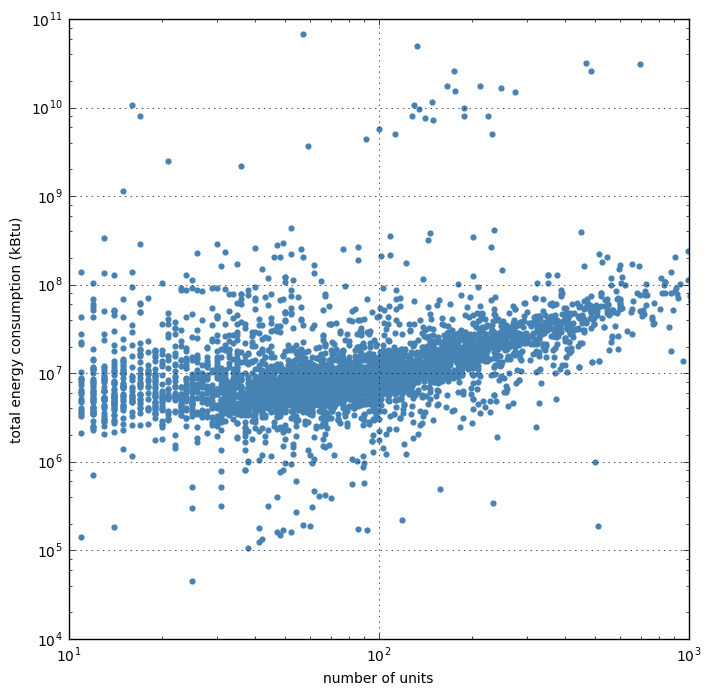

In [204]:
# make plot of the cut data

BBLnrgdata_cut.plot(y = 'energy_consum', x = 'UnitsTotal', marker = 'o', c = 'steelblue', kind = 'scatter', loglog=True, figsize = [8,8], lw = 0)
plt.ylim([1e4,1e11])
plt.xlim([1e1,1e3])
plt.xlabel('number of units')
plt.ylabel('total energy consumption (kBtu)')
plt.grid()

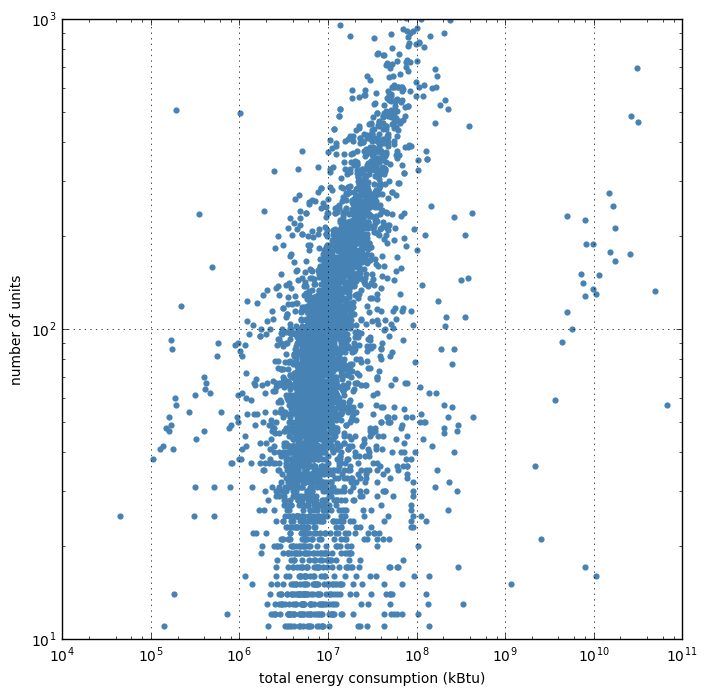

In [205]:
# plot it transposely
BBLnrgdata_cut.plot(x = 'energy_consum', y = 'UnitsTotal', marker = 'o', c = 'steelblue', kind = 'scatter', loglog=True, figsize = [8,8], lw = 0)
plt.xlim([1e4,1e11])
plt.ylim([1e1,1e3])
plt.ylabel('number of units')
plt.xlabel('total energy consumption (kBtu)')
plt.grid()

now we do the fitting:

In [206]:
# data cleaning. Select needed columns. Drop Nan.
df1 = BBLnrgdata_cut.iloc[:,(3,4)]
df1 = np.log10(df1)
df1 = df1.dropna()
df1.index = np.arange(0,len(df1))
df1.describe()

,energy_consum,UnitsTotal
count,4245.000000,4245.000000
mean,7.035041,1.903255
std,0.484722,0.406162
min,3.727866,1.041393
25%,6.768761,1.643453
50%,6.956754,1.880814
75%,7.242052,2.161368
max,10.831190,3.944483


In [207]:
# make a regression model with independt variable engergy consumption
# units total versus energy consumption

model1 = sm.OLS(df1['energy_consum'], sm.add_constant(df1['UnitsTotal'])).fit()
fit1 = model1.predict()

In [208]:
# make a regression model with independt variable engergy consumption
# energy consumption versus unitstotal

model2 = sm.OLS(df1['UnitsTotal'], sm.add_constant(df1['energy_consum'])).fit()
fit2 = model2.predict()

In [224]:
# calculate their chi-squared statistic
# y1 indicated log10(energy_consum). So we have to recover y1 through 10 ** y1 while calculating error
y1 = np.array(df1['energy_consum'])
y2 = np.array(df1['UnitsTotal'])
chisq1 = sum((fit1 - y1) ** 2 / abs(10 ** y1))
chisq2 = sum((fit2 - y2) ** 2 / abs(10 ** y2))

print ('chi-squared statistic for the first and second regression model is %f %f'%(chisq1, chisq2))


chi-squared statistic for the first and second regression model is 0.002328 17.360751


Chi-squared statistic for the first regression model is smaller, which indicates it fits better.

Now we do a 2nd degree polynomial fitting for units total versus energy consumption.

In [210]:
import statsmodels.formula.api as smf
df1['x'] = df1['UnitsTotal']
df1['x2'] = df1['x'] ** 2
df1['y'] = df1['energy_consum']
df1 = pd.DataFrame(df1)

model3 = smf.ols(formula = 'y ~ x2 + x', data = df1).fit()
fit3 = model3.predict()

In [211]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     575.0
Date:                Mon, 17 Oct 2016   Prob (F-statistic):          1.11e-221
Time:                        11:22:34   Log-Likelihood:                -2439.6
No. Observations:                4245   AIC:                             4885.
Df Residuals:                    4242   BIC:                             4904.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      7.4434      0.103     72.613      0.000         7.242     7.644
x2             0.3677      0.026     13.988      0.000         0.316     0.419
x             -0.9462      0.105     -9.028      0.000        -1.152    -0.741
==============================================================================
Omnibus:                     2252.273   Durbin-Watson:                   1.701
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            54935.374
Skew:                           2.018   Prob(JB):                         0.00
Kurtosis:                      20.155   Cond. No.                         104.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [212]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          energy_consum   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     912.4
Date:                Mon, 17 Oct 2016   Prob (F-statistic):          1.00e-181
Time:                        11:22:35   Log-Likelihood:                -2535.3
No. Observations:                4245   AIC:                             5075.
Df Residuals:                    4243   BIC:                             5087.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.0795      0.032    187.949      0.000         6.016     6.143
UnitsTotal     0.5021      0.017     30.207      0.000         0.469     0.535
==============================================================================
Omnibus:                     2221.496   Durbin-Watson:                   1.681
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            44684.548
Skew:                           2.042   Prob(JB):                         0.00
Kurtosis:                      18.361   Cond. No.                         11.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [213]:
LR = -2 * (-2535.3 - -2439.6)
LR_model = model3.compare_lr_test(model1)[0]
print ('LR is %f, LR from statsmodel is %f' %(LR, LR_model))

LR is 191.400000, LR from statsmodel is 191.416700


N_{DOF} = 2 - 1 = 1. According to the table, with $\alpha = 0.05$, p-value = 3.84. LR

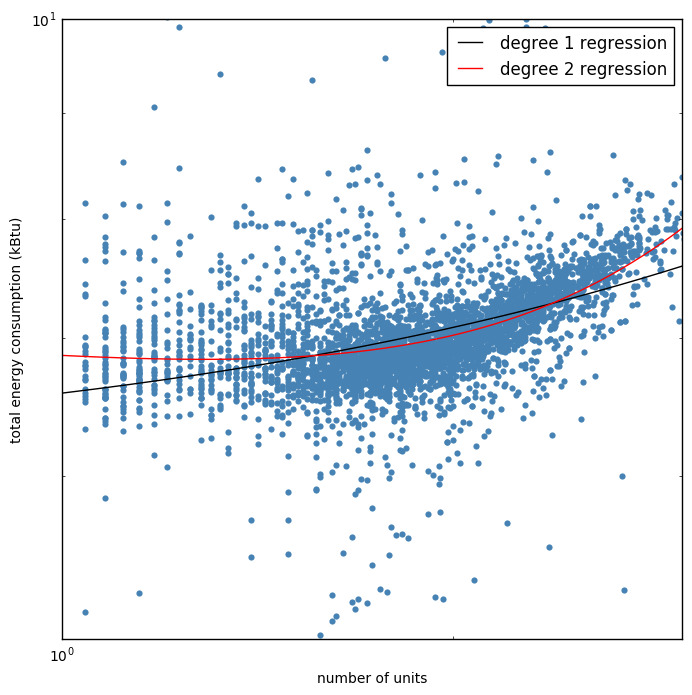

In [214]:
# plot of the log data and the two regression lines.
x_plot = np.linspace(1,3,5000)
y1_plot = model1.params[1]*x_plot + model1.params[0]
y2_plot = model3.params[1] * (x_plot**2) + model3.params[2]*x_plot + model3.params[0]

df1.plot(y = 'energy_consum', x = 'UnitsTotal', marker = 'o', c = 'steelblue', kind = 'scatter', loglog=True, figsize = [8,8], lw = 0)
plt.plot(x_plot, y1_plot, color = 'black', markersize = 1, label = 'degree 1 regression')
plt.plot(x_plot, y2_plot, color = 'red', markersize = 1, label = 'degree 2 regression')
plt.ylim([5,10])
plt.xlim([1,3])
plt.xlabel('number of units')
plt.ylabel('total energy consumption (kBtu)')
plt.legend()

# Extra credit 1

In [225]:
def rss(const, slope):
    '''return residues squared sum of regression function 
    and true function y1
    '''
    fit = slope * df1.UnitsTotal + const
    rss = sum((fit - df1.energy_consum) ** 2 / abs(y1))
    return rss

In [226]:
A = np.linspace(-100, 100, 200)
B = np.linspace(-50, 50, 200)

Lsurface = np.zeros((len(A), len(B)))

for i in range(len(A)):
    for j in range(len(B)):
        Lsurface[i][j] = rss(A[i], B[j])


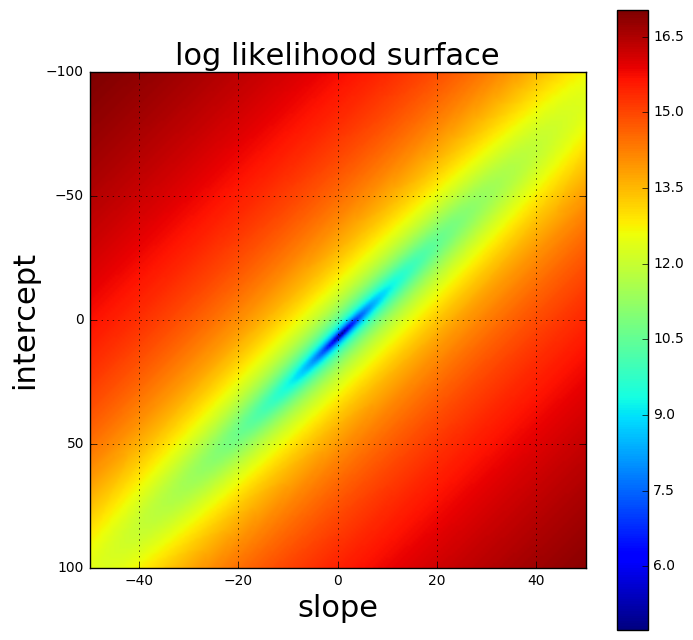

In [227]:
pl.figure(figsize=(8,8))
pl.title ("log likelihood surface", fontsize = 22)
pl.imshow(np.log(Lsurface), extent = [-50,50,100,-100], aspect=0.5)
pl.xlabel('slope', fontsize = 22)
pl.ylabel('intercept', fontsize = 22)
pl.grid()
pl.colorbar()

# Extra credit 2

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


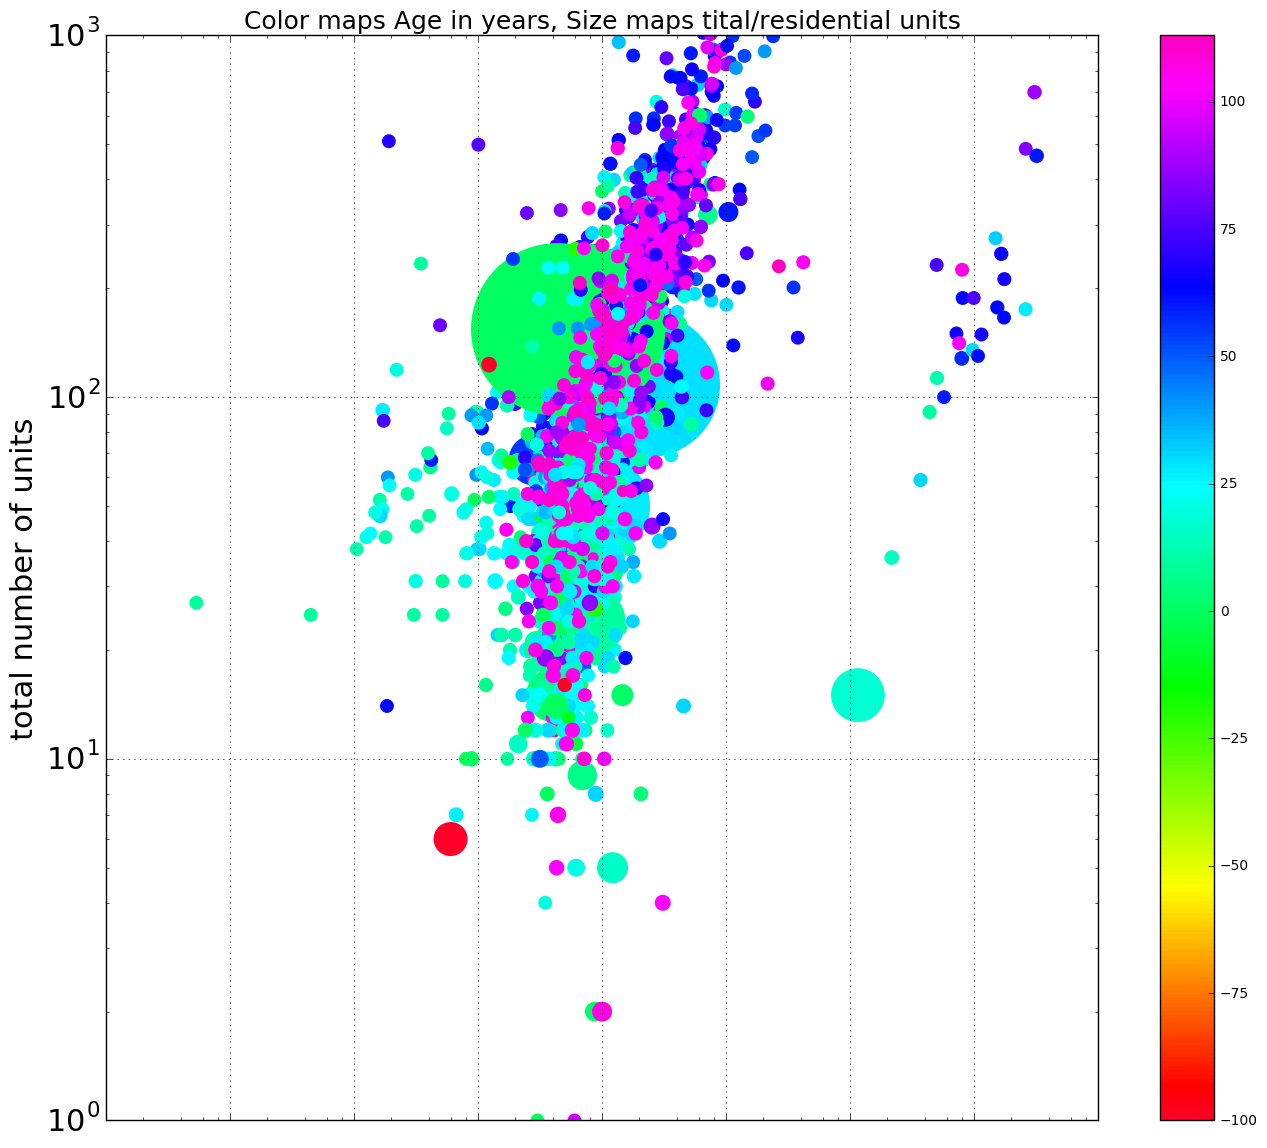

In [228]:
BBLnrgdata['YearBuilt'][BBLnrgdata['YearBuilt']<1800]=1800

BBLnrgdata.plot(kind='scatter',x='energy_consum',y='UnitsTotal', 
                fontsize=22, colormap='gist_rainbow', alpha = 1, 
                marker='o',  figsize=(16, 14), loglog=True,  
                xlim=(1000,1e11), ylim=(1,1000), 
                c=BBLnrgdata['YearBuilt']-1900, 
                s=BBLnrgdata['UnitsTotal']/BBLnrgdata['UnitsRes']*100, lw = 0)
pl.title('Color maps Age in years, Size maps tital/residential units', fontsize=18)
pl.ylabel("total number of units", fontsize=22)
pl.xlabel("total energy consumption (kBtu)", fontsize=22)
plt.grid()